# Time Series

## Red neuronales recurrentes RNN

Las RNN están específicamente diseñadas para trabajar con datos secuenciales como por ejemplo series de tiempo. También otros datos que se pueden considerar secuencias, como por ejemplo texto, que es lo que nos enfocamos cuando hacemos procesamiento de lenguaje natural, audio, música, trayectorias de coches, etc.

La idea fundamental es, partiendo de una secuencia, ¿podemos predecir una secuencia similar movida un tiempo adelante en el futuro? $[1,2,3,4] \rightarrow [1,2,3,4,5]$.

Una red neuronal pre-alimentada (**feed-forward**) es una red artificial donde las conexiones entre las unidades no forman un ciclo. A diferencia de las feed-forward, una RNN devuelve el output como nuevo input donde la salida del tiempo $t-1$ es el input del tiempo $t$ y este a su vez devuelve una salida que es el input del tiempo $t+1$. Se dice que las neuronas tienen memoria (**memory-cell**) puesto que en cada neurona tenemos como input el dato del tiempo actual más el output del tiempo anterior (información actual y del pasado). Estos inputs procedentes de neuronas anteriores se conocen como **hidden-inputs**.

Uno de los problemas de las RNN es que la información del principio se va perdiendo con el tiempo. Para solucionar este problema surgen las LSTM.

### Long-Short Term Memory LSTM

Introduce un nuevo componente en la arquitectura de red que tiene en cuenta el estado de la celda anterior.

- Entradas: input data $x_t$, hidden-layer $h_{t-1}$, y estado de la neurona anterior $C_{t-1}$.
- Cuatro capas intermedias: 
    - Forget Gate Layer. Capa que olvida cierta información.
    $$f_t = \sigma (W_f[h_{t-1} + x_t] + b_f)$$
    - Input Gate Layer. Agrega información que queremos conservar.
    $$i_t = \sigma (W_i[h_{t-1} + x_t] + b_i )$$
    - Estado de la neurona actual.
    $$\bar{C_t} = tanh(W_c[h_{t-1} + x_t] + b_c)$$
    - Nueva hidden-layer
    $$o_t = \sigma(W_o[h_{t-1} + x_t] + b_o))$$
- Combinación de información (a olvidar y permanecer) para producir nuevo estado de celda.
$$C_t = f_t*C{t-1} + i_t*\bar{C_t}$$
- Salida de nueva hidden-layer
$$h_t = o_t*tanh(C_t)$$

#### LSTM peepholes (con mirillas)

En cada capa intermedia dejamos que cada sigmoide pueda trabajar la información de la celda anterior.

$$f_t = \sigma (W_f[C_{t-1}, h_{t-1} + x_t] + b_f)$$
$$i_t = \sigma (W_i[C_{t-1}, h_{t-1} + x_t] + b_i )$$
$$o_t = \sigma(W_o[C_t, h_{t-1} + x_t] + b_o))$$

In [1]:
#!pip install keras

In [2]:
#!pip install tensorflow

In [3]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from sqlalchemy import create_engine

from local_settings import db_user, db_password, db_host, db_port, db_name

warnings.filterwarnings("ignore")

def datetime_to_timestamp(date):
    return datetime.timestamp(date)

def timestamp_to_datetime(timestamp):
    return datetime.fromtimestamp(timestamp)

def normalize_date(date):
    return date.strftime("%Y-%m-%d %H:%M:%S")

def psql_today(date):
    return date.strftime("%Y-%m-%d")

def to_seconds(data):
    return data.total_seconds()/3600


endpoint = f"postgres://{db_user}:{db_password}@{db_host}/{db_name}"
connection = create_engine(endpoint)
#connection = psycopg2.connect(user=db_user, password=db_password, host=db_host, port=db_port, database=db_name)

_TABLE_NAME = "incident"
_CUSTOMER = "test"
_BACK_TIME = 90
_VARIABLES = "id, discovered_date, create_date"
_NOW = psql_today(datetime.now())

sql_query = f"select {_VARIABLES} from {_TABLE_NAME} where org_name='{_CUSTOMER}' and discovered_date >= '{_NOW}'::date - interval '{_BACK_TIME} day'"
df = pd.read_sql_query(sql_query, connection, index_col="discovered_date")

print("Missing values: ", df.isna().sum())
_BATCH = "D"
serie = df.resample(_BATCH, base=1)["id"].agg(["count"])
#serie.fillna(methond="bfill")
serie.to_csv("../data/" + _CUSTOMER.lower() + "_incident_data.csv", index=True)
serie

Missing values:  id             0
create_date    0
dtype: int64


,count
discovered_date,
2020-08-25 00:00:00+00:00,6
2020-08-26 00:00:00+00:00,7
2020-08-27 00:00:00+00:00,21
2020-08-28 00:00:00+00:00,8
2020-08-29 00:00:00+00:00,0
...,...
2020-11-19 00:00:00+00:00,23
2020-11-20 00:00:00+00:00,9
2020-11-21 00:00:00+00:00,11


In [4]:
from sklearn.preprocessing import MinMaxScaler

_SIZE = int(len(serie) * 0.90)
train, test = serie.iloc[0:_SIZE], serie.iloc[_SIZE:len(serie)]

# Escalado
scaler = MinMaxScaler()
#scaler.fit(train)
#scaled_train = scaler.transform(train)
#scaled_test = scaler.transform(test)
scaled_full_data = scaler.fit_transform(serie)
scaled_train, scaled_test = scaled_full_data[0:_SIZE], scaled_full_data[_SIZE:len(serie)]

### Time Series Generator

Este generador toma una secuencia de puntos de datos (como una serie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento/validación.

In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator

# definimos generador de batches
# cada batch estará compuesto de n_inputs datos y predice una cantidad de batch_size
n_input = 7 # días atrás
n_features = 1
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=batch_size)
full_data_generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=n_input, batch_size=batch_size)

print("Tamaño de muestra de datos: ", len(scaled_train))
print("Tamaño de nuestro generador: ", len(generator)) # n_input afecta al tamaño

Tamaño de muestra de datos:  81
Tamaño de nuestro generador:  74


In [6]:
scaled_train[:5]

array([[0.17142857],
       [0.2       ],
       [0.6       ],
       [0.22857143],
       [0.        ]])

In [7]:
x, y = generator[0]
print("Datos: ", x.flatten())
print("Predicción: ", y)

Datos:  [0.17142857 0.2        0.6        0.22857143 0.         0.
 0.        ]
Predicción:  [[0.]]


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#early_stop = EarlyStopping(monitor="val_loss", patience=2)

# Creamos el modelo LSTM
model = Sequential()
# 100 neuronas, input_shape corresponde al shape del generator
model.add(LSTM(100, activation="relu", recurrent_activation="sigmoid", input_shape=(n_input, n_features), return_sequences=True))
# 100 neuronas
model.add(LSTM(100, activation='relu', return_sequences=False))
# 1 neurona para la salida final
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
#model.summary()
# se pasan al modelo los batches de datos, no la serie temporal
model.fit_generator(generator, epochs=100)#, callbacks=[early_stop], validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
74/74 [==============================] - 1s 10ms/step - loss: 0.0974 - accuracy: 0.0135
Epoch 2/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0620 - accuracy: 0.0270
Epoch 3/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0614 - accuracy: 0.0135
Epoch 4/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0628 - accuracy: 0.0135
Epoch 5/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0595 - accuracy: 0.0000e+00
Epoch 6/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0550 - accuracy: 0.0270
Epoch 7/100
74/74 [==============================] - 1s 15ms/step - loss: 0.0554 - accuracy: 0.0270
Epoch 8/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0516 - accuracy: 0.0270
Epoch 9/100
74/74 [==============================] - 1s 12ms/step - loss: 0.0509 - accuracy: 0.0270
Epoch 10/100
74/74 [

In [9]:
model.history.history.keys()

dict_keys(['loss', 'accuracy'])

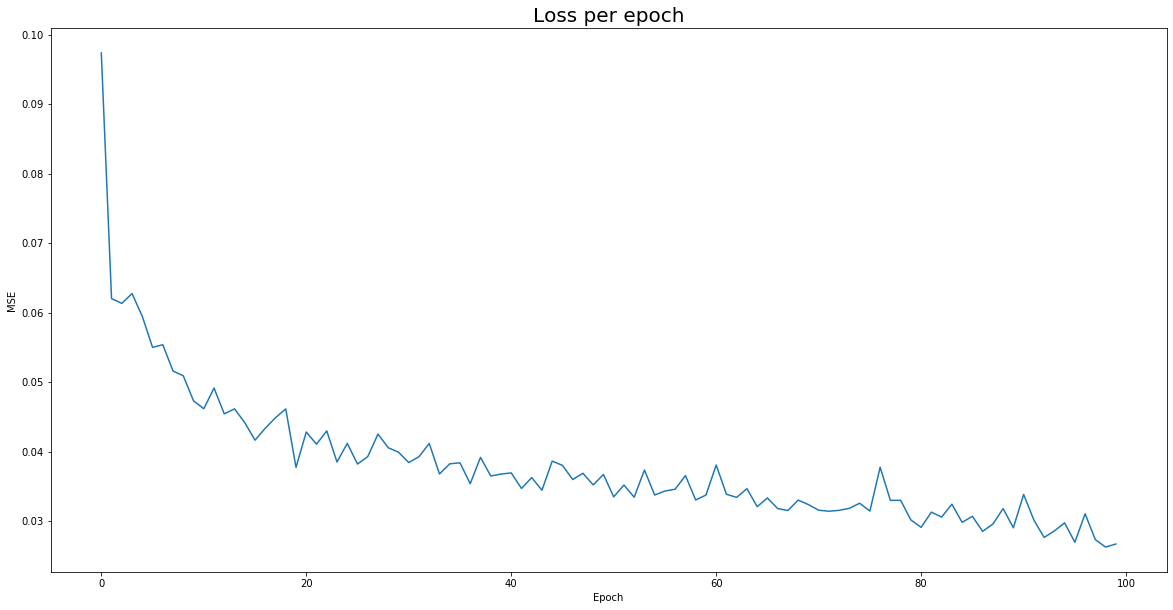

In [10]:
loss_per_epoch = model.history.history["loss"]
plt.figure(figsize=(20, 10))
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.title("Loss per epoch", size=20)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [11]:
# Evaluamos datos de test
# Como hemos elegido n_input (n_input días atrás), para predecir le tendremos
# que pasar datos al modelo en batches de n_input en n_input
first_eval_batch = scaled_train[-n_input:]
first_eval_batch
# nuestros datos de entrada deben tener el mismo shape que los del generator
print("Shape de nuestro generator: ", x.shape)

Shape de nuestro generator:  (1, 7, 1)


In [12]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

array([[0.22664055]], dtype=float32)

In [13]:
# Comparamos con nuestro test
scaled_test[0]

array([0.51428571])

In [14]:
predictions = []
first_eval_batch = scaled_train[-n_input:] # primer batch. Últimos n_input del training set
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # mismo shape que los del generator

for i in range(len(test)):
    #print("Iter ", i, "\n Batch \n", current_batch, "\n")
    current_pred = model.predict(current_batch)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

forecast = []
#current_batch = first_eval_batch.reshape((1, n_input, n_features))
next_days = 7

for i in range(next_days):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    
all_data = []
first_eval_batch = scaled_full_data[0:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # mismo shape que los del generator

for i in range(len(serie)):
    current_pred = model.predict(current_batch)[0]
    all_data.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

#predictions

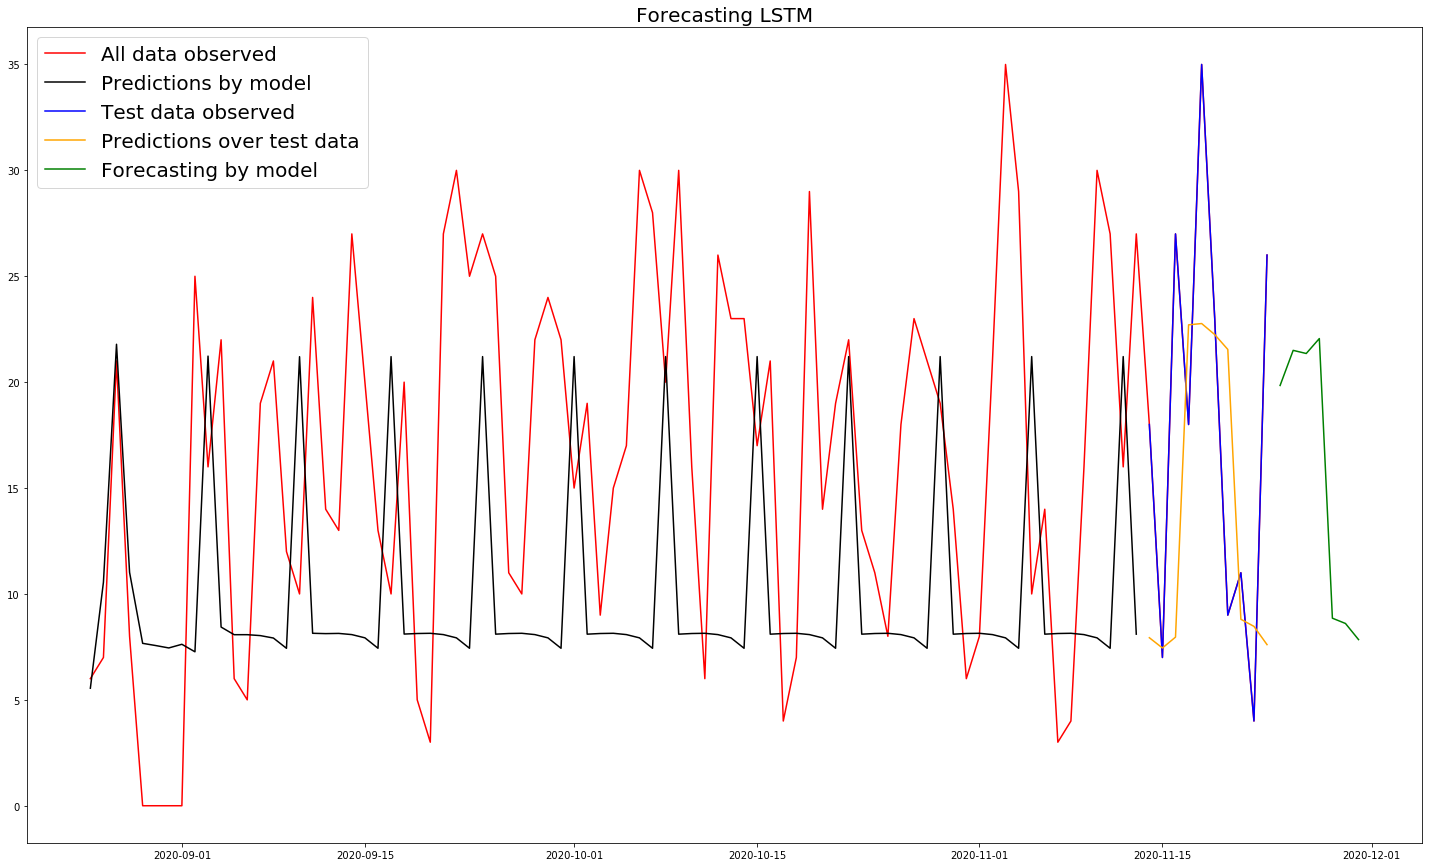

In [15]:
# Transformación inversa a observaciones no escaladas
true_predictions = scaler.inverse_transform(predictions)
forecast = scaler.inverse_transform(forecast)
model_data = scaler.inverse_transform(all_data)

# test.index[-1] + pd.Timedelta(days=1)
df_forecast = pd.DataFrame(forecast, index=[test.index[-1] + pd.DateOffset(i) for i in range(1, next_days + 1)])

test.columns = ["test_data"]
test["predictions"] = true_predictions
df_forecast.columns = ["forecast"]
serie["predictions"] = model_data

plt.figure(figsize=(25, 15))
plt.plot(serie.index, serie["count"], color="red", label="All data observed")
plt.plot(serie.index[:-len(test)], serie["predictions"][:-len(test)], color="black", label="Predictions by model")
plt.plot(test.index, test["test_data"], color="blue", label="Test data observed")
plt.plot(test.index, test["predictions"], color="orange", label="Predictions over test data")
plt.plot(df_forecast.index, df_forecast["forecast"], color="green", label="Forecasting by model")

plt.legend(loc="best", fontsize=20)
plt.title("Forecasting LSTM", size=20)
plt.show()

Las predicciones de modelo para todo el conjunto de datos (línea negra) es una muestra del deterioro del modelo y constituye un reflejo de:

- El modelo no es práctico para intervalos largos de tiempo.
- Al modelo deben pasarse los datos originales (observados). Si los batches se reajustan en base a las prediciiones del modelo entonces se perderá capacidad de predicción.

In [16]:
"""
# Guardar modelo
model.save("lstm_model.h5")
"""

'\n# Guardar modelo\nmodel.save("lstm_model.h5")\n'

In [17]:
"""
from keras.models import load_model

# Cargamos modelo
new_model = load_model("lstm_model.h5")
new_model.summary()
"""

'\nfrom keras.models import load_model\n\n# Cargamos modelo\nnew_model = load_model("lstm_model.h5")\nnew_model.summary()\n'